In [0]:
import torch
import numpy as np

In [0]:
import os 
import torchvision
import tarfile
from torchvision.datasets.utils import download_url

In [3]:
# Download Dataset
dataset_url = 'http://files.fast.ai/data/cifar10.tgz'
download_url(dataset_url, 'sample_data')

Using downloaded and verified file: sample_data/cifar10.tgz


In [0]:
with tarfile.open('sample_data/cifar10.tgz', 'r:gz') as tar:
  tar.extractall(path='cifar10/data')

In [5]:
data_dir = 'cifar10/data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/train')
print(classes)

['test', 'train', 'models', 'labels.txt']
['ship', 'deer', 'automobile', 'dog', 'airplane', 'horse', 'frog', 'truck', 'bird', 'cat']


### Data Augmentation and Normalization

In [0]:
# ImageFolder class enable to work with directory structure, one folder per class, used by many computer vision datasets 
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt

In [0]:
stats = ((0.4914, 0.4822, 0.4465),(0.2023,0.1994,0.2010))
train_tfms =  tt.Compose([tt.RandomCrop(32,padding=4,padding_mode='reflect'),
                          tt.RandomHorizontalFlip(),
                          tt.ToTensor(),
                          tt.Normalize(*stats)])

In [0]:
valid_tfms = tt.Compose([tt.ToTensor(),
                         tt.Normalize(*stats)])

In [0]:
train_ds = ImageFolder(data_dir+'/train',train_tfms)
valid_ds = ImageFolder(data_dir+'/test',valid_tfms)

In [0]:
batch_size = 256
from torch.utils.data.dataloader import DataLoader

#Training dataloader
train_loader = DataLoader(train_ds,batch_size,shuffle=True,num_workers=8,pin_memory=True)

#Validation dataloader
val_loader = DataLoader(valid_ds,batch_size,shuffle=False,num_workers=8,pin_memory=True)

In [0]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(16,16))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images[:100],10).permute(1,2,0))
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


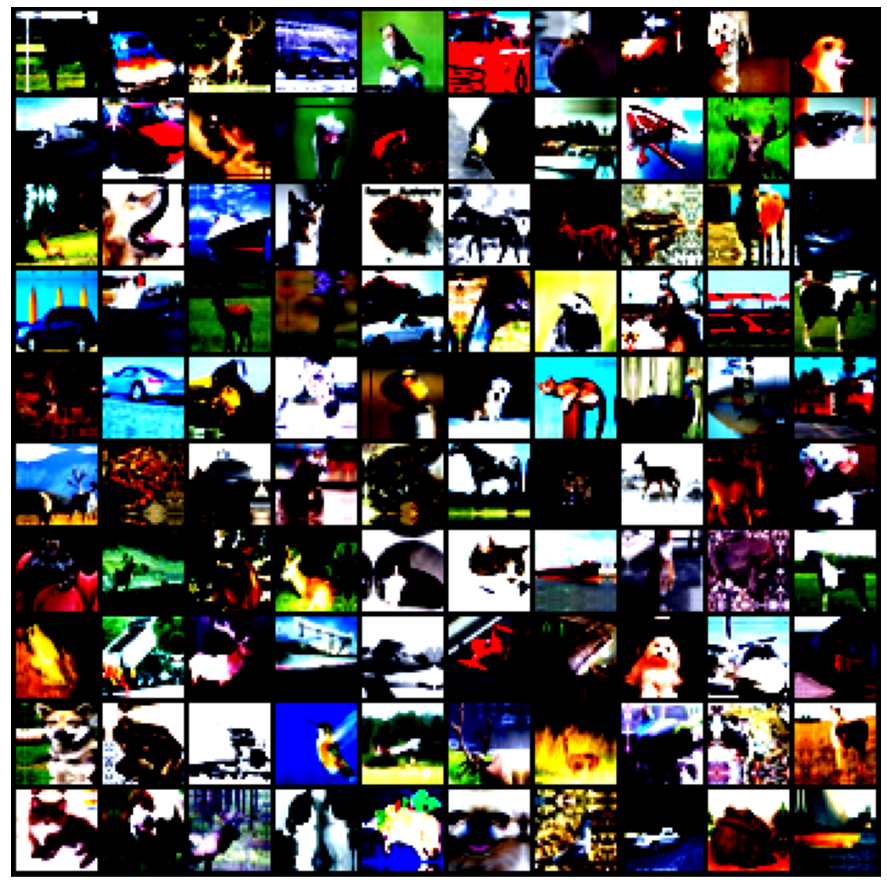

In [13]:
show_batch(train_loader)

### Model Building

In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class SimpleResidualBlock(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
    self.relu2 = nn.ReLU()
  
  def forward(self,x):
    out = self.conv1(x)
    out = self.relu1(out)
    out = self.conv2(out)
    out = self.relu2(out + x)
    return out

In [16]:
simple_resnet = SimpleResidualBlock()
for images,_ in train_loader:
  out = simple_resnet(images)
  print(out.shape)
  break

torch.Size([256, 3, 32, 32])


In [0]:
def conv_2d(ni,nf, stride=1, ks=3):
  return nn.Conv2d(in_channels=ni,out_channels=nf, kernel_size=ks, stride=stride, padding=ks//2, bias = False)

def bn_relu_conv(ni,nf):
  return nn.Sequential(nn.BatchNorm2d(ni),
                       nn.ReLU(inplace=True),
                       conv_2d(ni,nf))

In [0]:
class ResidulaBlock(nn.Module):
  def __init__(self,ni,nf,stride=1):
    super().__init__()
    self.bn = nn.BatchNorm2d(ni)
    self.conv1 = conv_2d(ni,nf,stride)
    self.conv2 = bn_relu_conv(nf,nf)
    self.shortcut = lambda x: x
    if ni != nf:
      self.shortcut = conv_2d(ni,nf,stride,1)
  
  def forward(self, x):
    x = F.relu(self.bn(x), inplace= True)
    r = self.shortcut(x)
    x = self.conv1(x)
    x = self.conv2(x) * 0.2
    return x.add_(r)

In [0]:
def make_group(N,ni,nf,stride):
  start = ResidulaBlock(ni,nf,stride)
  rest =  [ResidulaBlock(nf,nf) for j in range(1,N)]
  return [start]+rest

In [0]:
class Flatten(nn.Module):
  def __init__(self):
    super().__init__()
  
  def forward(self,x):
    return x.view(x.size(0),-1)

In [0]:
class WideResNet(nn.Module):
  def __init__(self, n_groups, N, n_classes, k=1, n_start=16):
    super().__init__()
    #Increase channels to n_start using conv layer
    layers = [conv_2d(3,n_start)]
    n_channels = [n_start]

    #Add groups of BasicBlock [Increase channels and downsmples]
    for i in range(n_groups):
      n_channels.append(n_start*(2**i)*k)
      stride = 2 if i>0 else 1
      layers += make_group(N,n_channels[i],n_channels[i+1],stride)
    
    # Pool, Flatten & add linear layer for classification
    layers += [nn.BatchNorm2d(n_channels[3]),
              nn.ReLU(inplace=True),
              nn.AdaptiveAvgPool2d(1),
              Flatten(),
              nn.Linear(n_channels[3], n_classes),
              nn.Softmax(dim=1)]
    self.features = nn.Sequential(*layers)
  
  def forward(self, x):
    return self.features(x)

In [0]:
def wrn_22():
  return WideResNet(n_groups=3, N=3, n_classes=10,k=6)

In [0]:
model = wrn_22()

In [24]:
model

WideResNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ResidulaBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (shortcut): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): ResidulaBlock(
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

### Training Model - Using FASTAi

In [0]:
from fastai.basic_data import DataBunch
from fastai.train import Learner
from fastai.metrics import accuracy

In [0]:
data = DataBunch.create(train_ds, valid_ds, bs=batch_size, path='cifar10/data/cifar10')
learner = Learner(data,model,loss_func=F.cross_entropy, metrics=[accuracy])
learner.clip = 0.1

In [27]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


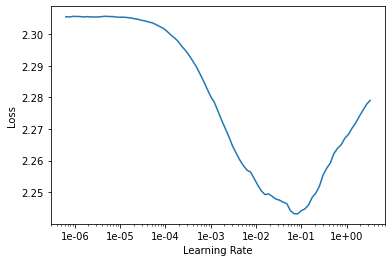

In [28]:
learner.recorder.plot()

In [29]:
learner.fit_one_cycle(25,5e-3,wd=1e-4) #WD=Weight decay

epoch,train_loss,valid_loss,accuracy,time
0,2.008834,1.979551,0.492500,00:58
1,1.906877,1.881295,0.577800,00:58
2,1.863782,2.012925,0.442700,00:58
3,1.840738,2.025532,0.432100,00:58
4,1.813470,1.854148,0.603400,00:58
5,1.802535,1.894055,0.564800,00:58
6,1.788871,1.871326,0.585800,00:58
7,1.770815,1.798693,0.661400,00:58
8,1.748255,1.804797,0.653800,00:58
9,1.725094,1.737109,0.721900,00:58


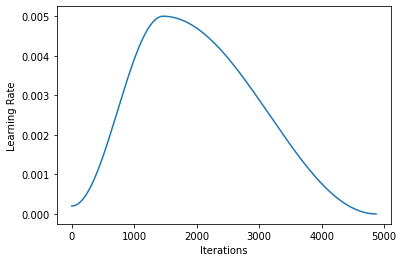

In [30]:
learner.recorder.plot_lr()

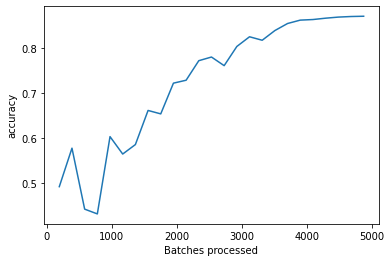

In [34]:
learner.recorder.plot_metrics()

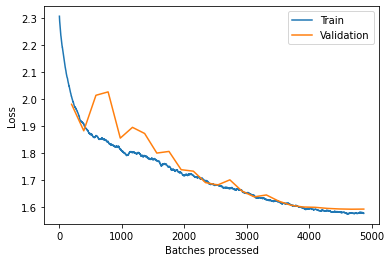

In [35]:
learner.recorder.plot_losses()